<a href="https://colab.research.google.com/github/GrainSack/GrainSack/blob/main/Class_Activation_Cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### TPU setting Google Amount

In [23]:
import os
import tensorflow as tf
# TensorFlow and tf.keras
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image


In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!echo $COLAB_TPU_ADDR

10.15.154.58:8470


In [4]:
# TPU gRPC 접근 URI
TPU_PATH = f"grpc://{os.environ['COLAB_TPU_ADDR']}"

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_PATH)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

In [5]:
strategy = tf.distribute.TPUStrategy(resolver)

### Load dataset

In [112]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs:0.2.0',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

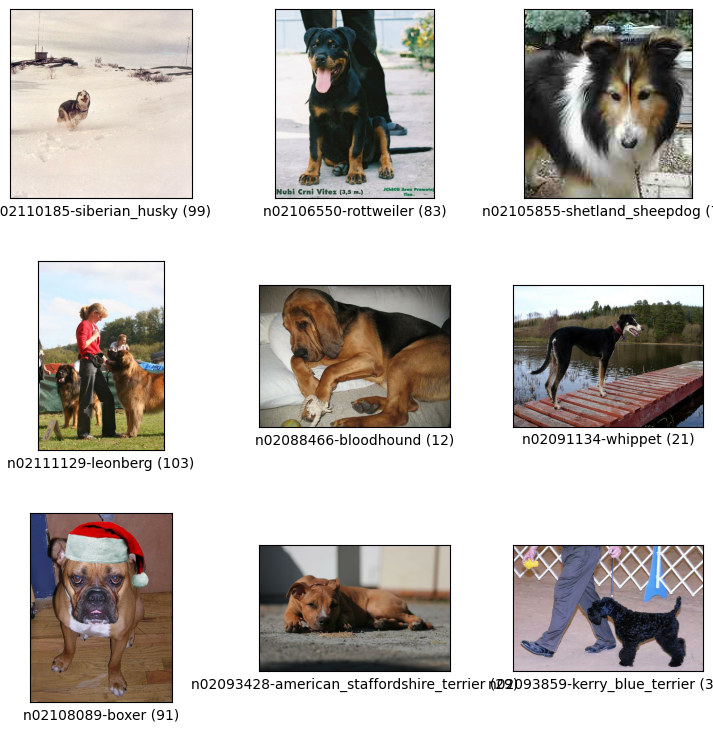

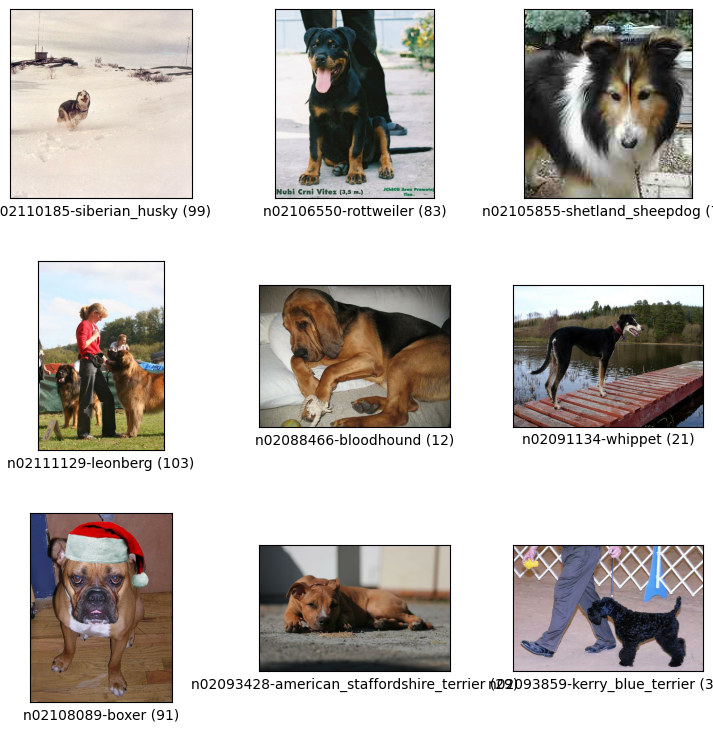

In [113]:
tfds.show_examples(ds_train, ds_info)

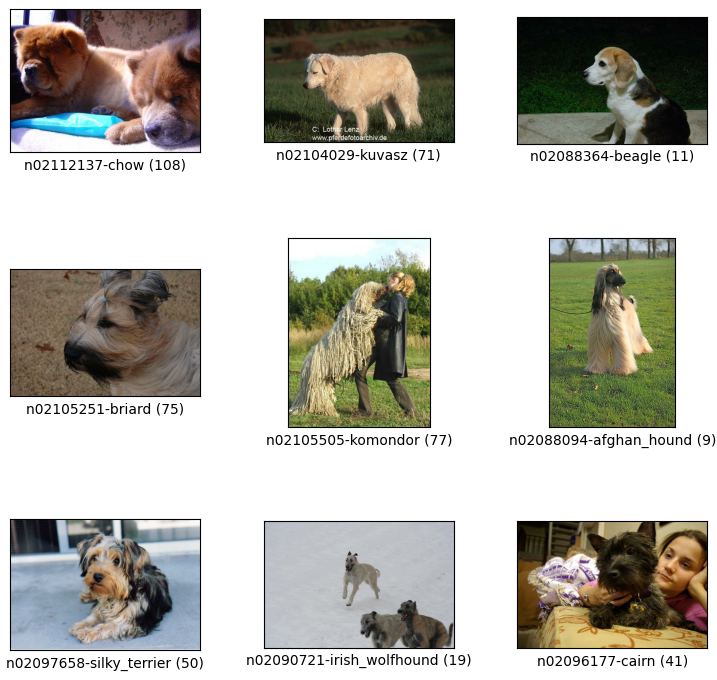

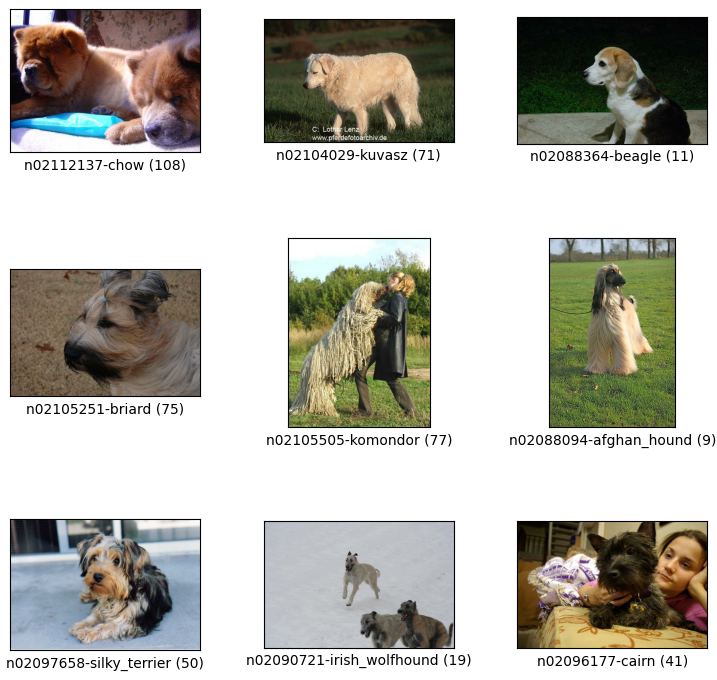

In [114]:
tfds.show_examples(ds_test, ds_info)

In [115]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
    }),
})

In [116]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',
)
x = base_model.output
x = keras.layers.Dense(64, activation='relu')(x)
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [ ]:
cam_model.summary()

In [118]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [119]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다.
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [120]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [121]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/32),
    validation_steps=int(ds_info.splits['test'].num_examples/32),
    epochs=2,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/2
750/750 [==============================] - 169s 205ms/step - loss: 3.2564 - accuracy: 0.2551 - val_loss: 3.5497 - val_accuracy: 0.1805
Epoch 2/2
750/750 [==============================] - 170s 226ms/step - loss: 1.1374 - accuracy: 0.6827 - val_loss: 1.4996 - val_accuracy: 0.5682


In [122]:
cam_model_path = '/content/drive/MyDrive/AIFFEL/cam_model1.h5'
cam_model.save(cam_model_path)

In [123]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

111


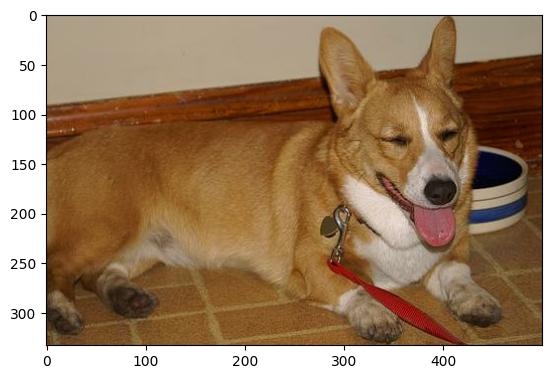

In [124]:
item = get_one(ds_train)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [125]:
cam_model_path = '/content/drive/MyDrive/AIFFEL/cam_model1.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [89]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]

    img_tensor, class_idx = normalize_and_resize_img(item)

    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-4].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]

    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0]

    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

In [126]:
cam_image = generate_cam(cam_model, item)

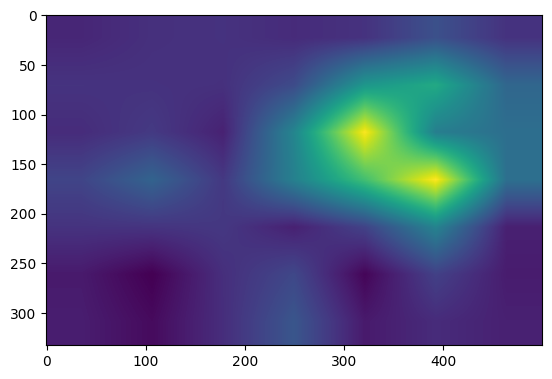

In [127]:
plt.imshow(cam_image)
plt.show()

In [128]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

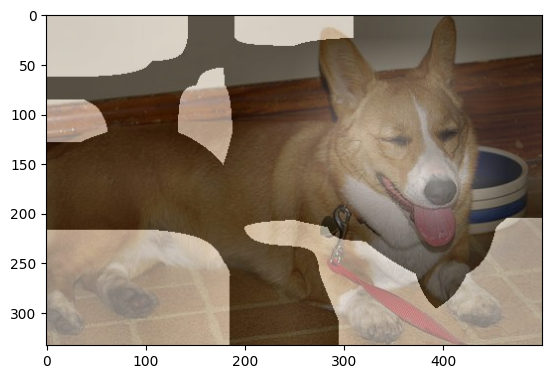

In [129]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

### Grad cam

In [93]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)

    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])

    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))

        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]

    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

In [ ]:
cam_model.summary()

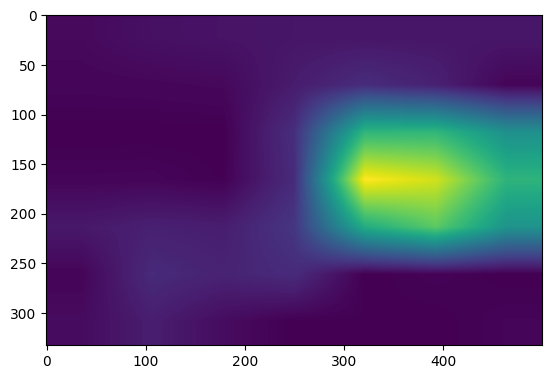

In [148]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

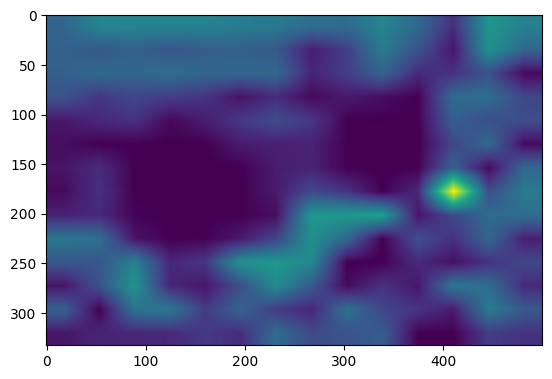

In [156]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

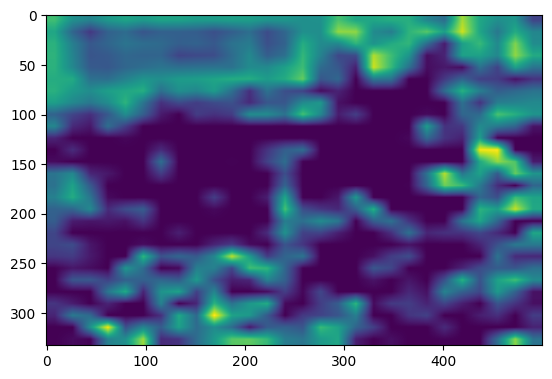

In [132]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

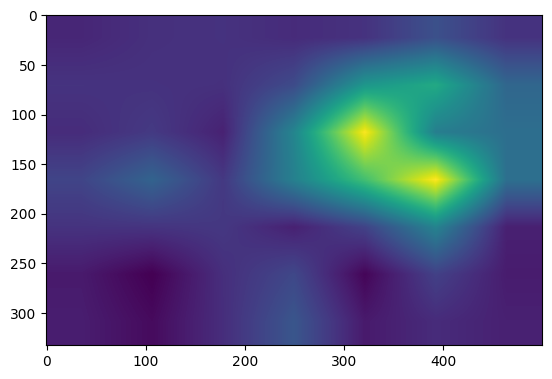

In [240]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [241]:
def get_bbox(cam_image, score_thresh=0.25):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)

    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    len(contours)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [242]:
rect = get_bbox(cam_image)
rect

array([[214, 164],
       [276,  -5],
       [528,  87],
       [466, 256]])

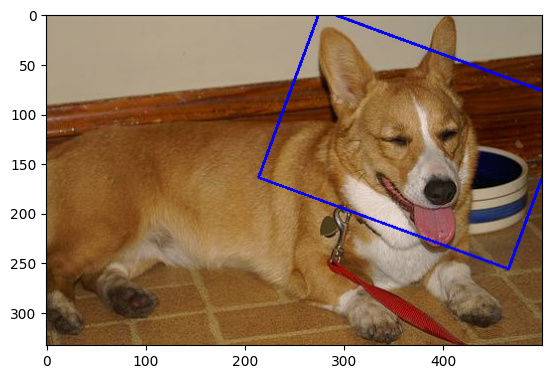

In [243]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [244]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다.
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [245]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.015015015015015015, 0.428, 0.7687687687687688, 1.056]

In [246]:
item['objects']['bbox']

array([[0.00900901, 0.        , 0.996997  , 0.926     ]], dtype=float32)

In [247]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])

    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [248]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.3677926702170316